In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


### Plot the number of ratings per movie and user

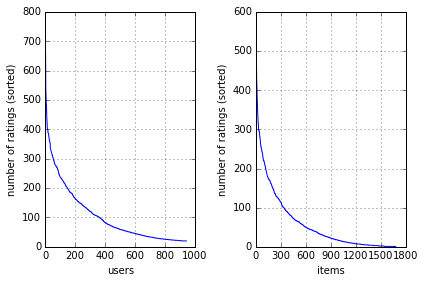

min # of items per user = 20, min # of users per item = 1.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [81]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    D = len(valid_items)
    N = len(valid_users)
    train = sp.lil_matrix((D,N))
    test = sp.lil_matrix((D,N))
    
    print("Matrix DXN =",D,"x",N)
    
    for i in range(0,D):
        rows,cols = valid_ratings[i,:].nonzero()
        for j in cols: #for all non-zero elems of that row
            if (np.random.randint(10)==0): #10% if data goes to test
                test[i,j]  = valid_ratings[i,j]
            else:
                train[i,j] = valid_ratings[i,j]
            
    print("valid_ratings shape", np.shape(valid_ratings))

    # ***************************************************
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # ***************************************************
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Matrix DXN = 1152 x 943
valid_ratings shape (1152, 943)
Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88141
Total number of nonzero elements in test data:9811


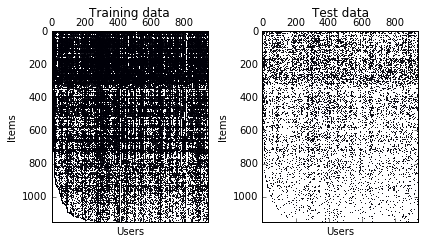

In [82]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [85]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    #from the pdf of this exercise lecture
    #return 1/(valid_ratings.nnz) * valid_ratings.sum()
    return 1/(train.nnz+test.nnz) * (train.sum()+test.sum())

baseline_global_mean(train, test)

3.5459817053250569

### Use the user means as the prediction

In [88]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    return 1/num_items * valid_ratings.sum(axis=0)

baseline_user_mean(train, test)

matrix([[ 0.82638889,  0.19618056,  0.13107639,  0.09027778,  0.42621528,
          0.66579861,  1.35416667,  0.19444444,  0.08159722,  0.66493056,
          0.54427083,  0.19444444,  1.62326389,  0.34461806,  0.25347222,
          0.52604167,  0.07378472,  0.91840278,  0.06163194,  0.12934028,
          0.39756944,  0.37065972,  0.47395833,  0.25520833,  0.27430556,
          0.2734375 ,  0.0703125 ,  0.25520833,  0.10763889,  0.140625  ,
          0.12239583,  0.11805556,  0.07725694,  0.06597222,  0.06510417,
          0.06163194,  0.17795139,  0.38020833,  0.07204861,  0.08767361,
          0.17013889,  0.59027778,  0.71180556,  0.47829861,  0.15017361,
          0.09635417,  0.07899306,  0.21354167,  0.48003472,  0.07378472,
          0.07118056,  0.20746528,  0.09288194,  0.20833333,  0.05989583,
          0.59114583,  0.31944444,  0.50086806,  1.29774306,  0.71961806,
          0.05381944,  0.65885417,  0.25      ,  0.61805556,  0.2734375 ,
          0.11458333,  0.09809028,  0.

### Use the item means as the prediction

In [141]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    return 1/num_users * valid_ratings.sum(axis=1)
    
baseline_item_mean(train, test)

matrix([[ 1.85365854],
        [ 0.44538706],
        [ 0.28950159],
        ..., 
        [ 0.03817603],
        [ 0.02969247],
        [ 0.03181336]])

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [142]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    num_items, num_users = train.shape
    user_features = sp.lil_matrix((num_features, num_users))
    item_features = sp.lil_matrix((num_features, num_items))
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [143]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # ***************************************************
    # calculate rmse (we only consider nonzero entries.) - page 4
    # ***************************************************
    tmp = data - item_features.dot(user_features.transpose())
    squared_val = tmp.multiply(tmp)  #POINT-wise multiplication, not product of matrices
    return 1/data.nnz * 1/2 * squared_val.sum()

In [140]:
#We dont specify K so we return a vector of the updates in all dimensions
def stoch_gradient_descent_z(x, d, n, z, w): #page 4
    return -(x[d,n] - w[d,:].dot(z[n,:].transpose())[0,0]) * w[n,:]
    
def stoch_gradient_descent_w(x, d, n, z, w):
    return -(x[d,n] - w[d,:].dot(z[n,:].transpose())[0,0]) * z[n,:]
    
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # TODO default:20. number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    
    user_features_T = user_features.transpose()
    item_features_T = item_features.transpose()
    
    counter = 0
    
    #TODO to run faster, use test instead of train data
    #nz_train=nz_test #TODO remove this
    #train=test       #TODO remove this
    for it in range(num_epochs):
        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)

        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
            # ***************************************************
            # do matrix factorization.
            # ***************************************************
            grad_z = stoch_gradient_descent_z(train, d, n, user_features_T, item_features_T)
            user_features_T[n] -= grad_z*gamma
            grad_w = stoch_gradient_descent_w(train, d, n, user_features_T, item_features_T)
            item_features_T[d] -= grad_w*gamma
            if counter % 1000 == 0:
                print("--status", counter, " of", len(nz_train))
            counter+=1
            
        rmse = compute_error(train,user_features_T, item_features_T, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        errors.append(rmse)
        
    # ***************************************************
    # evaluate the test error.
    # ***************************************************    
    rmse = compute_error(test, user_features_T, item_features_T, nz_test)
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)   

learn the matrix factorization using SGD...
--status 0  of 9811
--status 1000  of 9811
--status 2000  of 9811
--status 3000  of 9811
--status 4000  of 9811
--status 5000  of 9811
--status 6000  of 9811
--status 7000  of 9811
--status 8000  of 9811
--status 9000  of 9811
iter: 0, RMSE on training set: 6.847416165528488.
RMSE on test data: 6.847416165528488.


### Learn the Matrix Factorization using Alternating Least Squares

In [197]:
from scipy.sparse import csr_matrix
import scipy.sparse.linalg as spsl

def update_user_feature(
        x, w, lambda_user, k):
    """update user feature matrix."""
    
    # (w.transpose().dot(w) + lambda_user*sp.eye(k)).inverse().dot(w.transpose().dot(x))
    #to inverse we convert sparse matrix to CSR, then invert, then convert back
    tmp = w.transpose().dot(w) + lambda_user*sp.eye(k)
    inv_tmp = sp.lil_matrix(spsl.inv(sp.csr_matrix(tmp)))
    z = inv_tmp.dot(w.transpose()).dot(x)
    return z.transpose()

def update_item_feature(
        x, z, lambda_item, k):
    """update item feature matrix."""

    #(z.transpose().dot(z) + lambda_item*sp.eye(k)).inverse().dot(z.transpose().dot(x.transpose()))
    tmp = z.transpose().dot(z) + lambda_item*sp.eye(k)
    inv_tmp = sp.lil_matrix(spsl.inv(sp.csr_matrix(tmp)))
    w = inv_tmp.dot(z.transpose()).dot(x.transpose())
    return w.transpose()

In [199]:
from helpers import build_index_groups

def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS (first row is the )
    user_features, item_features = init_MF(train, num_features)
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    user_features[0,:] = train.mean(axis=0)  #should be axis=1 but matrix is transposed
    for i in range(1,num_features):
        user_features[i,:] = np.random.rand(np.size(user_features,1))

    item_features[0,:] = train.mean(axis=1).transpose()
    for i in range(1,num_features):
        item_features[i,:] = np.random.rand(np.size(item_features,1))

    user_features_T = user_features.transpose()
    item_features_T = item_features.transpose()

    # ***************************************************
    # start you ALS-WR algorithm.
    # ***************************************************

    for it in range(100):
        user_features_T = update_user_feature (train, item_features_T, lambda_user, num_features)
        item_features_T = update_item_feature (train, user_features_T, lambda_item, num_features)
        rmse = compute_error(train, user_features_T, item_features_T, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))

ALS(train, test)

/Users/bmagalha/anaconda/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:243: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/bmagalha/anaconda/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:161: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


iter: 0, RMSE on training set: 4.311636258286043.
iter: 1, RMSE on training set: 3.7468596025628402.
iter: 2, RMSE on training set: 3.654678967389026.
iter: 3, RMSE on training set: 3.6223685542937125.
iter: 4, RMSE on training set: 3.6072377432963285.
iter: 5, RMSE on training set: 3.5993589355470954.
iter: 6, RMSE on training set: 3.594905897820172.
iter: 7, RMSE on training set: 3.592164437893379.
iter: 8, RMSE on training set: 3.5903318671044984.
iter: 9, RMSE on training set: 3.589018533896814.
iter: 10, RMSE on training set: 3.5880277050848384.
iter: 11, RMSE on training set: 3.5872547746462167.
iter: 12, RMSE on training set: 3.586639762574013.
iter: 13, RMSE on training set: 3.586144738978412.
iter: 14, RMSE on training set: 3.5857432294550167.
iter: 15, RMSE on training set: 3.585415345141416.
iter: 16, RMSE on training set: 3.585145541208575.
iter: 17, RMSE on training set: 3.5849215066817077.
iter: 18, RMSE on training set: 3.584733508291204.
iter: 19, RMSE on training set: 

KeyboardInterrupt: 